In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('C:/Users/Ruoying/notebook/cp290/rental-listings-census/data/ba_block_variables.csv')

In [3]:
df.columns

Index([u'block_id', u'x', u'y', u'res_rents', u'res_values',
       u'square_meters_land', u'puma10_id', u'residential_unit_capacity',
       u'employment_capacity', u'rent_impute', 
       ...
       u'tracts_prop_persons_8', u'tracts_prop_persons_9', u'nodes_du_1500m',
       u'nodes_ave_year_built_3000m', u'tracts_prop_persons_5',
       u'tracts_prop_persons_6', u'tracts_prop_persons_7',
       u'tracts_prop_persons_1', u'tracts_prop_persons_2',
       u'tracts_prop_persons_3'],
      dtype='object', length=1015)

In [8]:
df_listing = pd.read_csv('C:/Users/Ruoying/notebook/cp290/rental-listings-census/data/sf_filtered.csv')

In [9]:
df_listing.columns

Index([u'Unnamed: 0', u'pid', u'date', u'region', u'neighborhood', u'rent',
       u'bedrooms', u'sqft', u'rent_sqft', u'longitude', u'latitude',
       u'county', u'fips_block', u'state', u'bathrooms', u'week', u'month',
       u'year', u'2014_median_income', u'2014_pop_est', u'census_name',
       u'median_income', u'population', u'block_id', u'bgpop', u'bgacres',
       u'bgjobs', u'bgmedkids', u'bgmedhhs', u'bgmedinc', u'proprent',
       u'lowinc1500m', u'highinc1500m', u'lnjobs5000m', u'lnjobs30km',
       u'lnpop400m', u'lnpop800m', u'lnjobs800m', u'propwhite', u'propblack',
       u'propasian', u'pumahhden', u'lnbasic3000m', u'lntcpuw3000m',
       u'pumajobden', u'lnjobs40km', u'lnret3000m', u'lnfire3000m',
       u'lnserv3000m', u'prop1per', u'prop2per', u'bgmedagehd', u'puma1',
       u'puma2', u'puma3', u'puma4', u'northsf', u'sqft1', u'sqft2',
       u'pct1per', u'pct2per', u'pctrent', u'pctblack', u'pctwhite',
       u'pctasian', u'y17jan', u'y17feb', u'y17mar', u'bgpopde

In [10]:
print(df.shape)

(109228, 1015)


In [11]:
print(df_listing.shape)

(16560, 71)


In [12]:
dfA = pd.merge(df_listing, df, on='block_id')


In [13]:
print(dfA.shape)

(16560, 1085)


In [20]:
cols_to_use = ['rent','rent_sqft','sqft','bedrooms','bathrooms','longitude', 'latitude',
'bgpop','bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m',
       'lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite',
       'propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m',
       'pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m',
       'prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3',
       'puma4', 'northsf', 'pct1per', 'pct2per', 'pctrent',
       'pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar',
       'bgpopden', 'bgjobden', 'highlowinc1500m']

x_cols = cols_to_use[2:]
y_col = 'rent'
print(len(x_cols))

49


In [22]:
# looks like outliers are already filtered. 

# nan's?
# about half of rows have bathrooms missing. Is it better to not use bathrooms feature? Or better to use it and drop Na's? 
df1 = dfA[cols_to_use]
print(len(df1))
df_notnull = df1.dropna(how='any')
print(len(df_notnull))
df2 = df_notnull

16560
8253


In [16]:
def RMSE(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

def cross_val_gb(X,y,cv_method='kfold',k=5, **params):
    """Estimate gradient boosting regressor using cross validation.
    
    Args: 
        X (DataFrame): features data
        y (Series): target data
        cv_method (str): how to split the data ('kfold' (default) or 'timeseries')
        k (int): number of folds (default=5)
        **params: keyword arguments for regressor
    Returns: 
        float: mean error (RMSE) across all training/test sets.
    """
    if cv_method == 'kfold':
        kf = KFold(n_splits=k, shuffle=True, random_state=2012016)  # use random seed for reproducibility. 
    
    E = np.ones(k)   # this array will hold the errors. 
    i=0
    for train, test in kf.split(X, y): 
        train_data_x = X.iloc[train]
        train_data_y = y.iloc[train]    
        test_data_x = X.iloc[test]
        test_data_y = y.iloc[test]

        # n_estimators is number of trees to build. 
        grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
        grad_boost.fit(train_data_x,train_data_y)
        predict_y=grad_boost.predict(test_data_x)
        E[i] = RMSE(test_data_y, predict_y)
        i+=1
    return np.mean(E)

In [23]:
df_X = df2[x_cols]
df_y = df2[y_col]

In [24]:
params = {'n_estimators':100,
          'learning_rate':0.1,
          'max_depth':1,
          'min_samples_leaf':4
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, **params)

577.98493424571313

In [26]:
# find best model using different parameter
param_grid = {'learning_rate':[5,.2,.1],
              'max_depth':[6,8,12],
              'min_samples_leaf': [17,25],
              'max_features': [.3]
              }

est= GradientBoostingRegressor(n_estimators = 100)
gs_cv = GridSearchCV(est,param_grid).fit(df_X,df_y)

print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'max_features': 0.3, 'learning_rate': 0.1, 'max_depth': 12, 'min_samples_leaf': 17}
0.65108327979


In [28]:
# best parameters
params = {'n_estimators':500,
          'learning_rate':0.1,
          'max_depth':12,
          'min_samples_leaf':17,
          'max_features':.3
          }
grad_boost = GradientBoostingRegressor(loss='ls',criterion='mse', **params)
grad_boost.fit(df_X,df_y)
cross_val_gb(df_X,df_y, cv_method='kfold',k=5, **params)

372.89313384924384

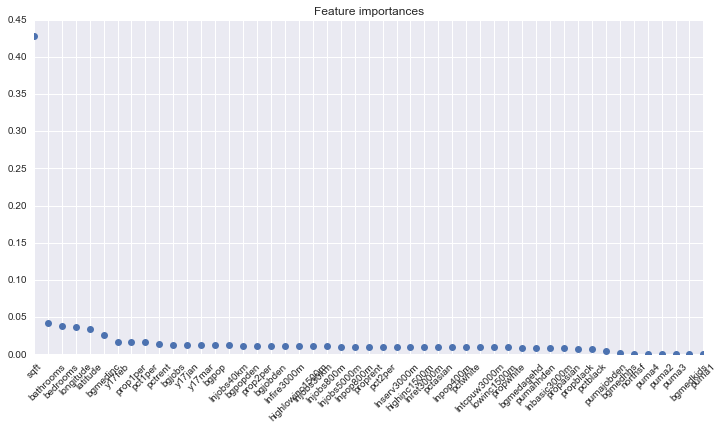

In [32]:
# plot the importances
gb_o = pd.DataFrame({'features':x_cols,'importance':grad_boost.feature_importances_})
gb_o= gb_o.sort('importance',ascending=False)


plt.figure(1,figsize=(12, 6))
plt.xticks(range(len(gb_o)), gb_o.features,rotation=45)
plt.plot(range(len(gb_o)),gb_o.importance,"o")
plt.title('Feature importances')
plt.show()

In [33]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

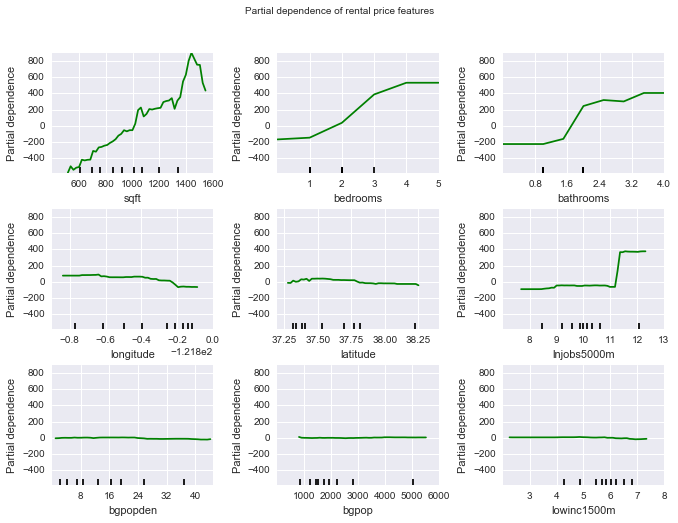

In [34]:
features = [0,1,2,3,4, 13, 46,5,11]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (10,8))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

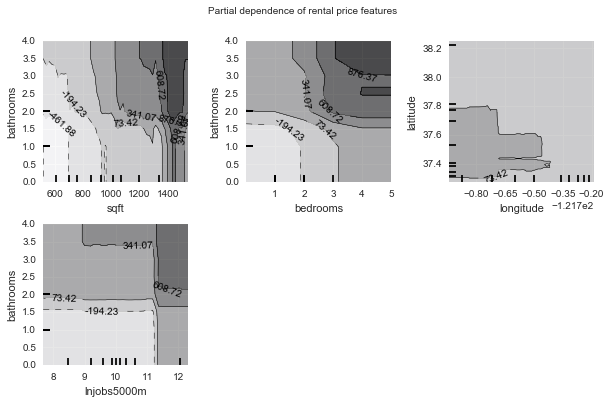

In [35]:
# interact variables and see their partial dependence
features = [(0,2),(1,2),(3,4),(13,2)]
names = df_X.columns
fig, axs = plot_partial_dependence(grad_boost, df_X, features,feature_names=names, grid_resolution=50, figsize = (9,6))
fig.suptitle('Partial dependence of rental price features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show()

try new features

In [ ]:
cols_to_use = ['rent','rent_sqft','sqft','bedrooms','bathrooms','longitude', 'latitude',
'bgpop','bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m',
       'lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite',
       'propblack', 'propasian', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m',
       'pumajobden', 'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m',
       'prop1per', 'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3',
       'puma4', 'northsf', 'pct1per', 'pct2per', 'pctrent',
       'pctblack', 'pctwhite', 'pctasian', 'y17jan', 'y17feb', 'y17mar',
       'bgpopden', 'bgjobden', 'highlowinc1500m']

x_cols = cols_to_use[2:]
y_col = 'rent'
print(len(x_cols))

In [ ]:
# looks like outliers are already filtered. 

# nan's?
# about half of rows have bathrooms missing. Is it better to not use bathrooms feature? Or better to use it and drop Na's? 
df1 = dfA[cols_to_use]
print(len(df1))
df_notnull = df1.dropna(how='any')
print(len(df_notnull))
df2 = df_notnull

In [ ]:
df_X = df2[x_cols]
df_y = df2[y_col]